In [1]:
import pandas as pd
# import random
# import itertools
import datetime as dt
import matplotlib.pyplot as plt
import calendar
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('pared_turnstile.csv', low_memory=False)

In [3]:
df.head()

,Unnamed: 0,STATION,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS,zipcode,hir,TRAFFIC
0,0,59 ST,6625470,2245312,2018-05-19 00:00:00,24.0,2.0,10022.0,10610.0,26.0
1,1,59 ST,6625494,2245314,2018-05-19 04:00:00,20.0,24.0,10022.0,10610.0,44.0
2,2,59 ST,6625514,2245338,2018-05-19 08:00:00,81.0,77.0,10022.0,10610.0,158.0
3,3,59 ST,6625595,2245415,2018-05-19 12:00:00,196.0,66.0,10022.0,10610.0,262.0
4,4,59 ST,6625791,2245481,2018-05-19 16:00:00,227.0,39.0,10022.0,10610.0,266.0


In [4]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%Y-%m-%d %H:%M:%S')
df['TOTAL'] = df['ENTRY_DIFFS'] + df['EXIT_DIFFS']
df.set_index('DATETIME', inplace=True)
df.drop(['Unnamed: 0','ENTRY_DIFFS','EXIT_DIFFS','ENTRIES','EXITS','zipcode','hir'], axis=1, inplace=True)

Time of entries is not always in 4-hour increments. Re-sample dataframe to correct for this, for plotting

In [5]:
df2 = df.groupby(['STATION']).resample(rule='4H').sum().reset_index()
df2['DAY_OF_WEEK'] = df2['DATETIME'].dt.weekday
df2['DATE'] = df2['DATETIME'].dt.date
df2['TIME'] = df2['DATETIME'].dt.time

In [6]:
df2.head()

,STATION,DATETIME,TRAFFIC,TOTAL,DAY_OF_WEEK,DATE,TIME
0,1 AV,2018-05-19 00:00:00,2794.0,2794.0,5,2018-05-19,00:00:00
1,1 AV,2018-05-19 04:00:00,1714.0,1714.0,5,2018-05-19,04:00:00
2,1 AV,2018-05-19 08:00:00,6442.0,6442.0,5,2018-05-19,08:00:00
3,1 AV,2018-05-19 12:00:00,10255.0,10255.0,5,2018-05-19,12:00:00
4,1 AV,2018-05-19 16:00:00,11301.0,11301.0,5,2018-05-19,16:00:00


### Sum over all data

to get a list of high-volume stations

### Heatmap: volume of traffic by day of week & time of day, for a given station

In [7]:
def hm_data_dow_time(s, data_col, dow):
    '''Generates heatmap data for day-of-week x time-of-day
    Inputs:
        s (string) = station name
        data_col (string)  = data column in df2 (e.g. 'ENTRY_DIFFS')
        dow (integer) = day of week, an integer from 0-6, with 0 being Monday
    Output: 
        List of lists of data_col summed over day of week and station, grouped by time
    '''
    assert dow in range(7), "dow must be an integer between 0-6"
    
    return df2[(df2['DAY_OF_WEEK'] == dow) & (df2['STATION'] == s)].groupby('TIME')[data_col].sum()

In [30]:
def heatmap_grid_4x4(station_list, fig_title, filename='temp'):
    '''Inputs: station_list (list) = list of station names
               fig_title (string) = Figure Title
        Output:
            4x4 grid of heatmaps, plotting total volume (entries + exits) by day of week & time of day
    '''
    
    vmax = df2['TOTAL'].max() * 1.5
    vmin = df2['TOTAL'].min()
    
    xlabel_hm = [str(int(x)) + 'h' for x in np.linspace(0,20,6)]
    ylabel_hm = calendar.day_name[:]
    
    fig, ax = plt.subplots(4,4, figsize=(20,20))
    plt.suptitle(fig_title, fontsize=20)

    for i, s in enumerate(station_list):
        plt.subplot(4,4,i+1)

        if i % 4 == 0:
            ylabel=ylabel_hm
        else:
            ylabel=False

        if i > 11:
            xlabel=xlabel_hm
        else:
            xlabel=False

        hm_data = [hm_data_dow_time(s, 'TOTAL', d) for d in range(7)]
        sns.heatmap(hm_data, xticklabels = xlabel, yticklabels=ylabel, 
                    cbar=False, cmap='coolwarm')
        plt.title(s)
    
    if filename != 'temp':
        plt.savefig(filename + '.svg', dpi=180, transparent=True)

In [37]:
final_station_list

array(['96 ST', '81 ST-MUSEUM', '72 ST-2 AVE', '86 ST-2 AVE',
       '66 ST-LINCOLN', 'CLARK ST'], dtype=object)

Generate dummy data to test functions:

In [9]:
grp2 = df2.groupby(['STATION'])['TOTAL'].sum().reset_index()

highest_vol = list(set(grp2.sort_values('TOTAL').tail(16)['STATION']))
lowest_vol = list(set(grp2.sort_values('TOTAL').head(16)['STATION']))
rand_vol = list(set(grp2.sort_values('TOTAL').sample(16)['STATION']))

n = len(grp2)

mid_vol = list(set(grp2.sort_values('TOTAL').iloc[(n//2)-8:(n//2)+8]['STATION']))

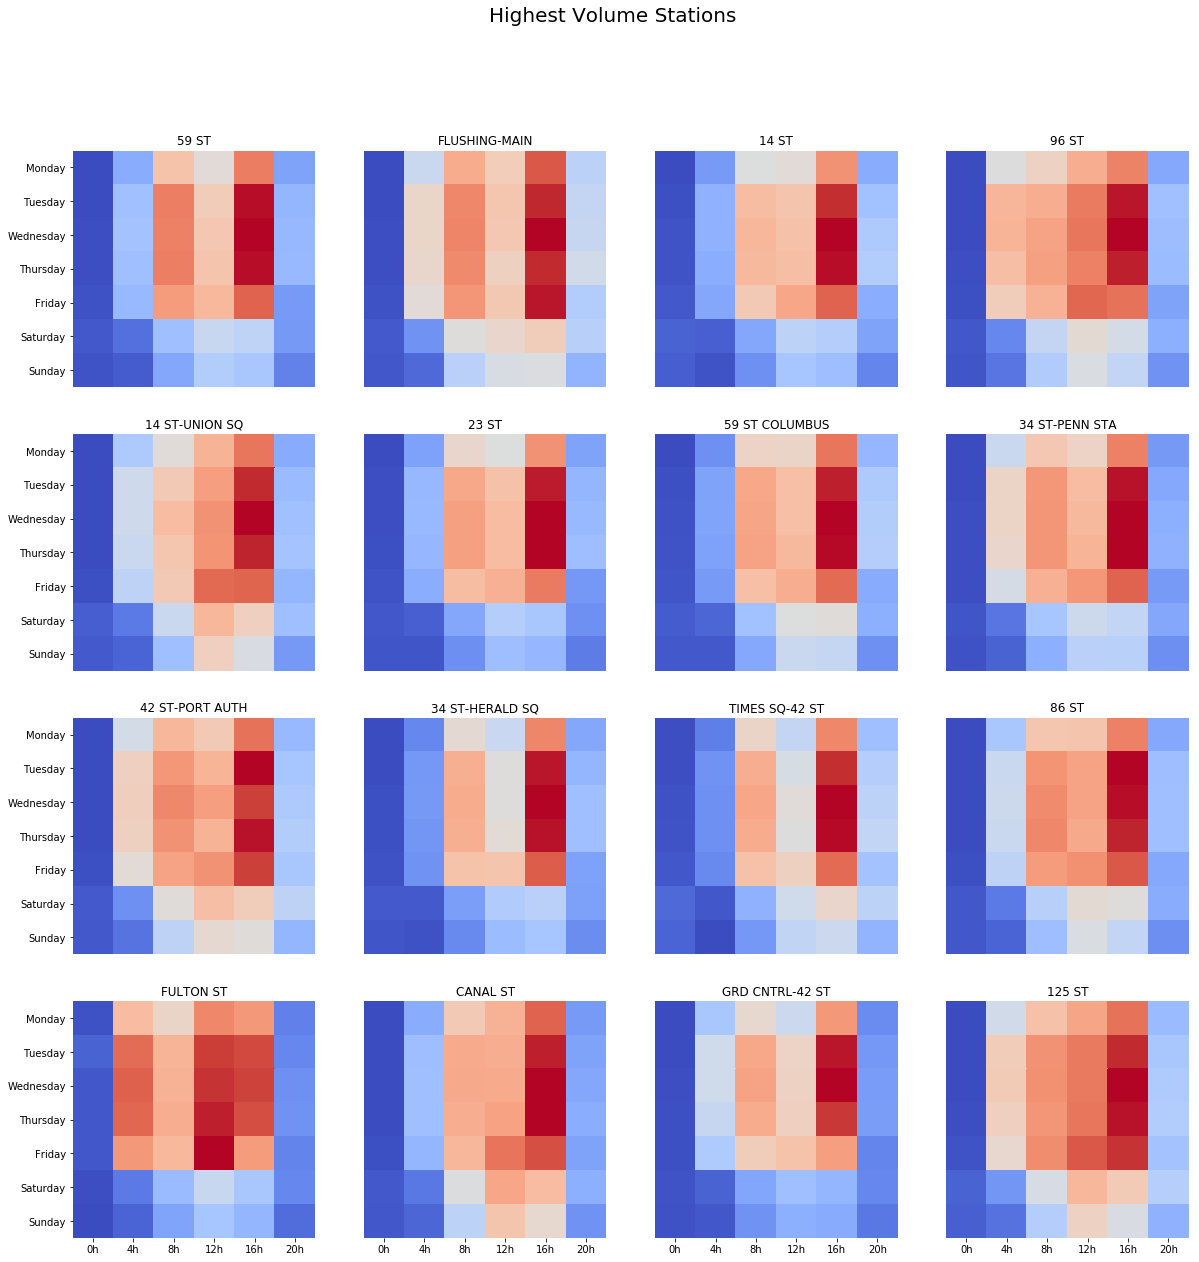

In [10]:
heatmap_grid_4x4(highest_vol, 'Highest Volume Stations')

In [12]:
twofer = ['FULTON ST', '14 ST-UNION SQ']

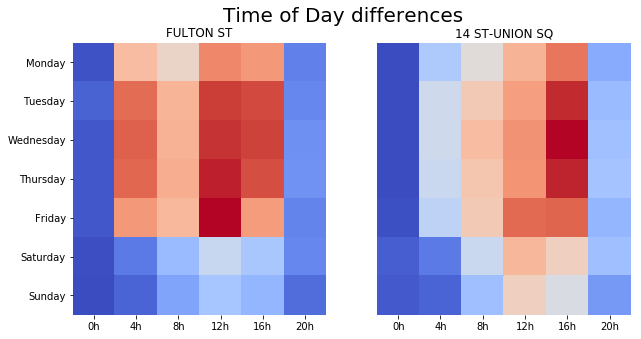

In [29]:
heatmap_1x2(twofer, 'Time of Day differences', filename='heatmap_tod_diff')

In [31]:
final_data = pd.read_csv('filtered.csv')

In [43]:
final_data.drop(5, inplace=True)

In [44]:
final_station_list = final_data['STATION'].values

In [45]:
len(final_station_list)

5

In [72]:
def heatmap_grid_1x5(station_list, fig_title, filename='temp'):
    '''Inputs: station_list (list) = list of station names
               fig_title (string) = Figure Title
                filename (string) = filename, with extension, if desired to save figure
        Output:
            4x4 grid of heatmaps, plotting total volume (entries + exits) by day of week & time of day
    '''
    
    vmax = df2['TOTAL'].max() * 1.5
    vmin = df2['TOTAL'].min()
    
    xlabel_hm = [str(int(x)) + 'h' for x in np.linspace(0,20,6)]
    ylabel_hm = [x[:3] for x in calendar.day_name]
    
    fig, ax = plt.subplots(1,5, figsize=(20,4))
    plt.suptitle(fig_title, fontsize=20, y=1.05)

    for i, s in enumerate(station_list):
        plt.subplot(1,5,i+1)

        if i == 0:
            ylabel=ylabel_hm
            cbar=False
        elif i == 4:
            ylabel=False
            cbar=True
        else:
            ylabel=False
            cbar=False

        xlabel=xlabel_hm

        hm_data = [hm_data_dow_time(s, 'TOTAL', d) for d in range(7)]
        sns.heatmap(hm_data, xticklabels = xlabel, yticklabels=ylabel, 
                    cbar=False, cmap='coolwarm')
        plt.title(s, fontsize=16)
    
    if filename != 'temp':
        plt.savefig(filename, dpi=180, transparent=True)

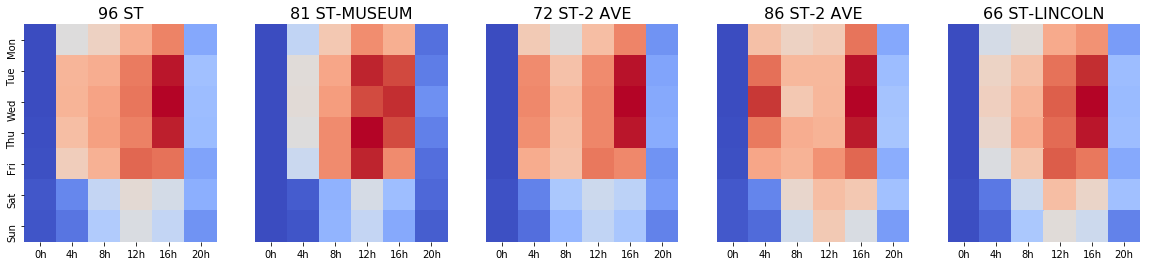

In [73]:
heatmap_grid_1x5(final_station_list, '', 'final_station_heatmaps.svg')